# Making Own Mock Data
The last bit of mock data that was tried (in `work-with-true.ipynb`) already contained selection effects that distorted the 35M$_\odot$ bump that the code was trying to pin down. To see if the algorithm can even handle it at all and to see what the selection effects do to the analysis, mock data data without selection effects need to be generated and tested, which is what we're doing here

In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as con
from astropy.cosmology import Planck18
from scipy.integrate import quad
from tqdm import tqdm
import warnings
from scipy import integrate
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

%matplotlib inline

## Generating data points

In [2]:
# Parameters:

N = int(1E3) # Number of data points

### Mass function: all mass in units of M_sun
m_scale = -2.35 # exponent in exponential function
m_min = 5 # minimum mass
m_max = 100 # maximum mass
m_bump = 35 # location of bump
sigma_bump = 5 # width of bump

frac_bump = 0.3 # fraction of BH in bump

In [3]:
def P(m, alpha=m_scale, mmin=m_min):
    '''Converts X~Uniform[0,1] to bounded Power law with slope alpha and min value m_min'''    
    ma = mmin**alpha
    return (ma + (-ma)*m)**(1/alpha)

def generate_masses(N_samples=N, f=frac_bump, m_b=m_bump, sigma=sigma_bump, alpha=m_scale, mmin=m_min):
    '''Generate masses based on mass function for black holes.
       Distribution follows power law with gaussian bump, tunable with arguments'''
    
    mass_array = np.zeros(N_samples)
    in_bump = np.random.rand(N_samples) < f #pick which distribution each point goes in

    for i, point in enumerate(in_bump):
        if point: #if point is going into the bump distribution
            # random seed
            mass_array[i] = np.random.normal(m_b, sigma)

        else: # going into exponential instead
            mass_array[i] = P(np.random.rand(), alpha=alpha, mmin=mmin)
    return mass_array

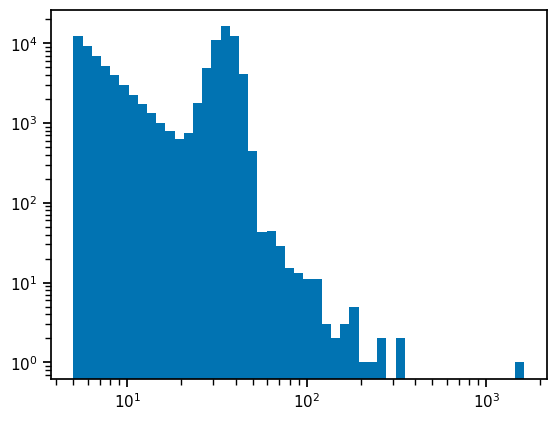

In [4]:
### Plotting Power law just to make sure it works properly

samples = generate_masses(int(1E5), f=0.5)

plt.hist(samples, bins=np.logspace(np.log10(5), np.log10(max(samples)), 50))
plt.yscale('log')
plt.xscale('log')

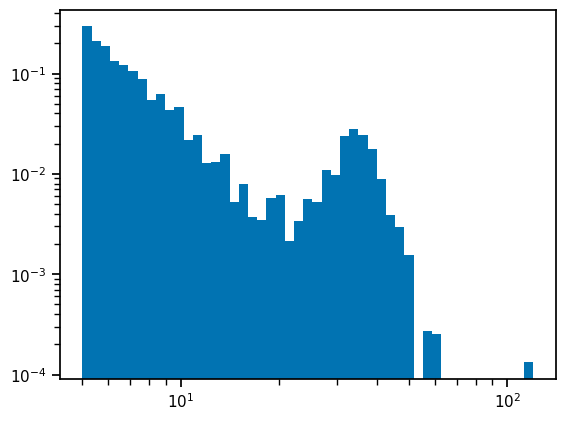

In [5]:
mass_array = np.zeros(N)
dl_array   = np.zeros(N)
z_array    = np.zeros(N)

in_bump = np.random.rand(N) < frac_bump #pick which distribution each point goes in

for i, point in enumerate(in_bump):
    if point: #if point is going into the bump distribution
        mass_array[i] = np.random.normal(m_bump, sigma_bump)
        
    else: # going into exponential
        mass_array[i] = P(np.random.rand())
plt.hist(mass_array, bins=np.logspace(np.log10(m_min), np.log10(max(mass_array)), 50), density=True)
plt.xscale('log')
plt.yscale('log')